# Solve for Gaussian approximations using optimization

In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [7]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e0

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

## optimize to improve fit

In [24]:
import jax
import jax.numpy as jnp
from jax import grad, jit, value_and_grad


num_patches = 10000 
seed = 10

patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


learning_rate = 2.976e-05
momentum = 5.258e-02
batch_size = 27

cov_mat_optimized, cov_mat_initial, mean_vec, best_loss = run_optimization(patches, momentum, learning_rate, batch_size, eigenvalue_floor=1e-3)
print (f'optimized loss: {best_loss}')

Initial loss:  531725.80876659
optimized loss: 455.2678199844352661665


Text(0, 0.5, 'Eigenvalue')

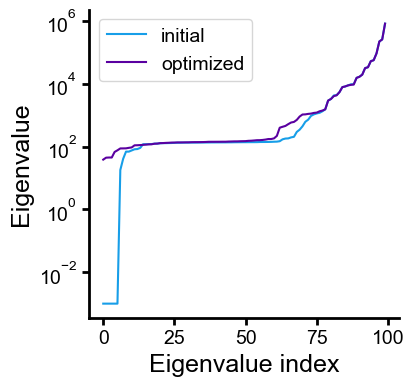

In [46]:
# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

## Generate samles using unoptimized and optimized covariance matrices

precomputing masks and variances: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


generating samples


generating sample: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


Text(0.5, 0.98, 'Sample size: 40, patch_size: 10, prefer iterative: False')

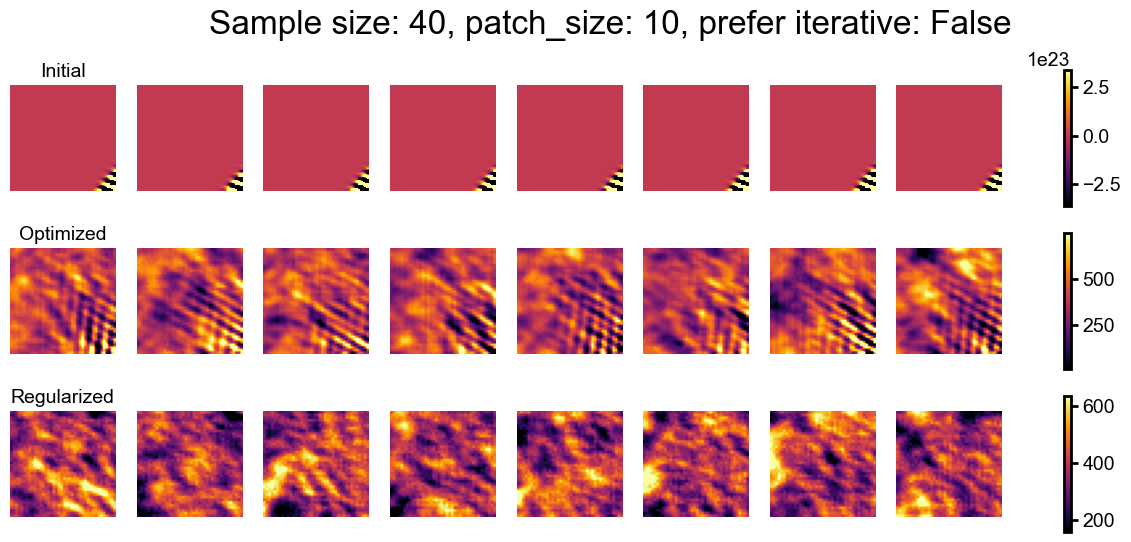

In [75]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

# create a regularized cov mat by making a larger eigenvalue floor
eigvals, eigvecs = onp.linalg.eigh(cov_mat_optimized)
eigvals = np.where(eigvals < 5e2, 5e2, eigvals)
cov_mat_regularized = eigvecs @ np.diag(eigvals) @ eigvecs.T

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_regularized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_regularized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)

fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6), sharex=True, sharey=True)
vmin_initial, vmax_initial = np.percentile(samples_initial, 1), np.percentile(samples_initial, 99)
vmin_optimized, vmax_optimized = np.percentile(samples_optimized, 1), np.percentile(samples_optimized, 99)
vmin_regularized, vmax_regularized = np.percentile(samples_regularized, 1), np.percentile(samples_regularized, 99)
for i in range(num_samples):
    im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_initial, vmax=vmax_initial)
    im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
    im3 = axs[2, i].imshow(samples_regularized[i], cmap='inferno', vmin=vmin_regularized, vmax=vmax_regularized)
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
axs[0, 0].set_title('Initial')
axs[1, 0].set_title('Optimized')
axs[2, 0].set_title('Regularized')

# add colorbars
fig.colorbar(im1, ax=axs[0, :], location='right')
fig.colorbar(im2, ax=axs[1, :], location='right')
fig.colorbar(im3, ax=axs[2, :], location='right')

fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}, prefer iterative: {prefer_iterative_sampling}')

Text(0, 0.5, 'Eigenvalue')

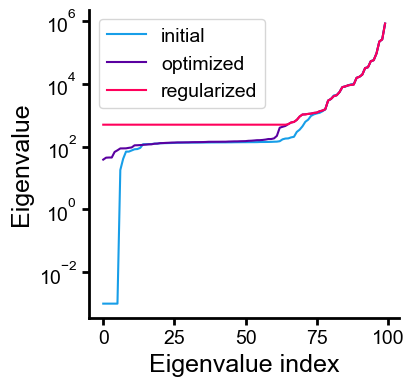

In [76]:
# plot eignevalues of different cov mats
eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)
eig_vals_regularized = np.linalg.eigvalsh(cov_mat_regularized)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.semilogy(eig_vals_initial, label='initial')
axs.semilogy(eig_vals_optimized, label='optimized')
axs.semilogy(eig_vals_regularized, label='regularized')
axs.legend()

clear_spines(axs)
axs.set_xlabel('Eigenvalue index')
axs.set_ylabel('Eigenvalue')

In [77]:
optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
regularized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_regularized, mean_vec).mean()

print(f'Initial likelihood: {initial_likelihood}')
print(f'Optimized likelihood: {optimized_likelihood}')
print(f'Regularized likelihood: {regularized_likelihood}')

precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 142.78it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 161.80it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 150.01it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 139.77it/s]

Initial likelihood: -475900.2529350949
Optimized likelihood: -466.46800496940267
Regularized likelihood: -475.1970473935327


## Fix with early stopping?

In [ ]:
def run_optimization(data, momentum, learning_rate, batch_size, eigenvalue_floor=1e-3, patience=100, validation_fraction=0.1):
    patch_size = int(np.sqrt(np.prod(np.array(data.shape)[1:])))
    # Initialize parameters, hyperparameters
    mean_vec = np.ones(patch_size**2) * np.mean(data)
    patch_size = int(np.sqrt(np.prod(np.array(data.shape)[1:])))

    # Split data into training and validation sets
    num_validation = int(len(data) * validation_fraction)
    num_train = len(data) - num_validation
    train_data = data[:num_train]
    validation_data = data[num_train:]

    # initialize covariance matrix so likelihood is not nan
    cov_mat_initial = compute_stationary_cov_mat(train_data, eigenvalue_floor=eigenvalue_floor)

    initial_evs, initial_eig_vecs = make_valid_stationary(*np.linalg.eigh(cov_mat_initial), eigenvalue_floor, patch_size)
    print('Initial loss: ', loss_function(initial_evs, initial_eig_vecs, mean_vec, train_data[:batch_size]))

    cov_mat_initial = initial_eig_vecs @ np.diag(initial_evs) @ initial_eig_vecs.T

    if np.isnan(jax.scipy.stats.multivariate_normal.logpdf(train_data[0].flatten(), mean=mean_vec, cov=cov_mat_initial)):
        raise ValueError("Initial likelihood is nan")
    
    # Training loop
    eigvals = initial_evs
    eig_vecs = initial_eig_vecs
    velocity = np.zeros_like(eigvals)
    best_loss = np.inf
    key = jax.random.PRNGKey(onp.random.randint(0, 100000))
    best_loss_iter = 0
    train_loss_history = []
    validation_loss_history = []
    for i in range(1000):
        # select a random batch
        batch_indices = jax.random.randint(key, shape=(batch_size,), minval=0, maxval=num_train)
        key, subkey = jax.random.split(key)
        batch = train_data[batch_indices]
        
        eigvals, eig_vecs, velocity, train_loss = optmization_step(eigvals, eig_vecs, velocity, 
                                                             batch, mean_vec, momentum, learning_rate, eigenvalue_floor, patch_size)

        validation_loss = loss_function(eigvals, eig_vecs, mean_vec, validation_data)   
        train_loss_history.append(train_loss)
        validation_loss_history.append(validation_loss)

        print(f"Iteration {i+1}, Loss: {loss}", end='\r')
        if validation_loss < best_loss:
            best_loss_iter = i
            best_loss = validation_loss
            best_eigvals = eigvals
            best_eig_vecs = eig_vecs
        if i - best_loss_iter > patience:
            break

        
    eigvals, eig_vecs = make_valid_stationary(best_eigvals, best_eig_vecs, eigenvalue_floor, patch_size=patch_size)
    best_cov_mat = eig_vecs @ np.diag(eigvals) @ eig_vecs.T
    return best_cov_mat, cov_mat_initial, mean_vec, best_loss, train_loss_history, validation_loss_history



learning_rate = 2.976e-05
momentum = 5.258e-02
batch_size = 27

cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history = run_optimization(
    patches, momentum, learning_rate, batch_size, eigenvalue_floor=1e-3)

# plot train and validation loss
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.plot(train_loss_history, label='train')
